In [ ]:
import os
import random
from dataclasses import dataclass
from typing import Any
import pandas as pd
import torch
from torch.utils.data import DataLoader
import cv2
from dataset import FathomNetMultiLabelDataset
from typing import Dict, List
import json
import matplotlib as plt


In [23]:
def load_category_key(path: str) -> Dict[int, Dict[str, str]]:
    df = pd.read_csv(path)
    mapping = {}
    for _, row in df.iterrows():
        mapping[int(row["id"])] = {"name": str(row["name"]), "supercat": str(row["supercat"])}

    return mapping


In [24]:
cat_key_path = './category_key.csv'
train_json_path = '../../object_detection/train.json'
train_csv_path = '../../multilabel_classification/train.csv'


df = pd.read_csv(train_csv_path)
mapping = load_category_key(cat_key_path)

In [25]:
df.head()

,id,categories
0,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1.0]
1,dce21f7c-20e5-482b-bd90-c038f8464c03,[1.0]
2,4a7f2199-772d-486d-b8e2-b651246316b5,[1.0]
3,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1.0, 9.0, 11.0, 88.0]"
4,3f735021-f5de-4168-b139-74bf2859d12a,"[1.0, 37.0, 51.0, 119.0]"


In [26]:
keys = list(mapping.keys())
print(keys)
print(mapping[keys[0]])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [27]:
print(df['categories'].head())

0                       [1.0]
1                       [1.0]
2                       [1.0]
3      [1.0, 9.0, 11.0, 88.0]
4    [1.0, 37.0, 51.0, 119.0]
Name: categories, dtype: object


In [28]:
import ast
df['categories_names'] = df['categories'].apply(
    lambda cat_str: [mapping[int(float(cat_id))]['name'] for cat_id in ast.literal_eval(cat_str)]
)

In [30]:
df.head()

,id,categories,categories_names
0,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1.0],[Actiniaria]
1,dce21f7c-20e5-482b-bd90-c038f8464c03,[1.0],[Actiniaria]
2,4a7f2199-772d-486d-b8e2-b651246316b5,[1.0],[Actiniaria]
3,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1.0, 9.0, 11.0, 88.0]","[Actiniaria, Liponema brevicorne, Actinopteryg..."
4,3f735021-f5de-4168-b139-74bf2859d12a,"[1.0, 37.0, 51.0, 119.0]","[Actiniaria, Merluccius productus, Sebastes, R..."


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5950 entries, 0 to 5949
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                5950 non-null   object
 1   categories        5950 non-null   object
 2   categories_names  5950 non-null   object
dtypes: object(3)
memory usage: 139.6+ KB


In [34]:
with open('../../data_splits/train_ids.json') as inp:
    train_ids = json.load(inp)

with open('../../data_splits/val_ids.json') as inp:
    val_ids = json.load(inp)


train_df = df[df['id'].isin(train_ids)]
val_df = df[df['id'].isin(val_ids)]


train_df.info()
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5089 entries, 0 to 5949
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                5089 non-null   object
 1   categories        5089 non-null   object
 2   categories_names  5089 non-null   object
dtypes: object(3)
memory usage: 159.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 3 to 5946
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                860 non-null    object
 1   categories        860 non-null    object
 2   categories_names  860 non-null    object
dtypes: object(3)
memory usage: 26.9+ KB


In [37]:
# Flatten the list of lists to get all category names
all_train_labels = [label for sublist in train_df['categories_names'] for label in sublist]
train_unique_labels = set(all_train_labels)

all_val_labels = [label for sublist in val_df['categories_names'] for label in sublist]
val_unique_labels = set(all_val_labels)

print(f"Number of unique labels in train set: {len(train_unique_labels)}")
print(f"Number of unique labels in val set: {len(val_unique_labels)}")

difference = val_unique_labels - train_unique_labels
print(f"Labels in val set but not in train set: {difference}")

Number of unique labels in train set: 129
Number of unique labels in val set: 79
Labels in val set but not in train set: {'Benthopecten', 'Farrea', 'Chonelasma', 'Careproctus'}


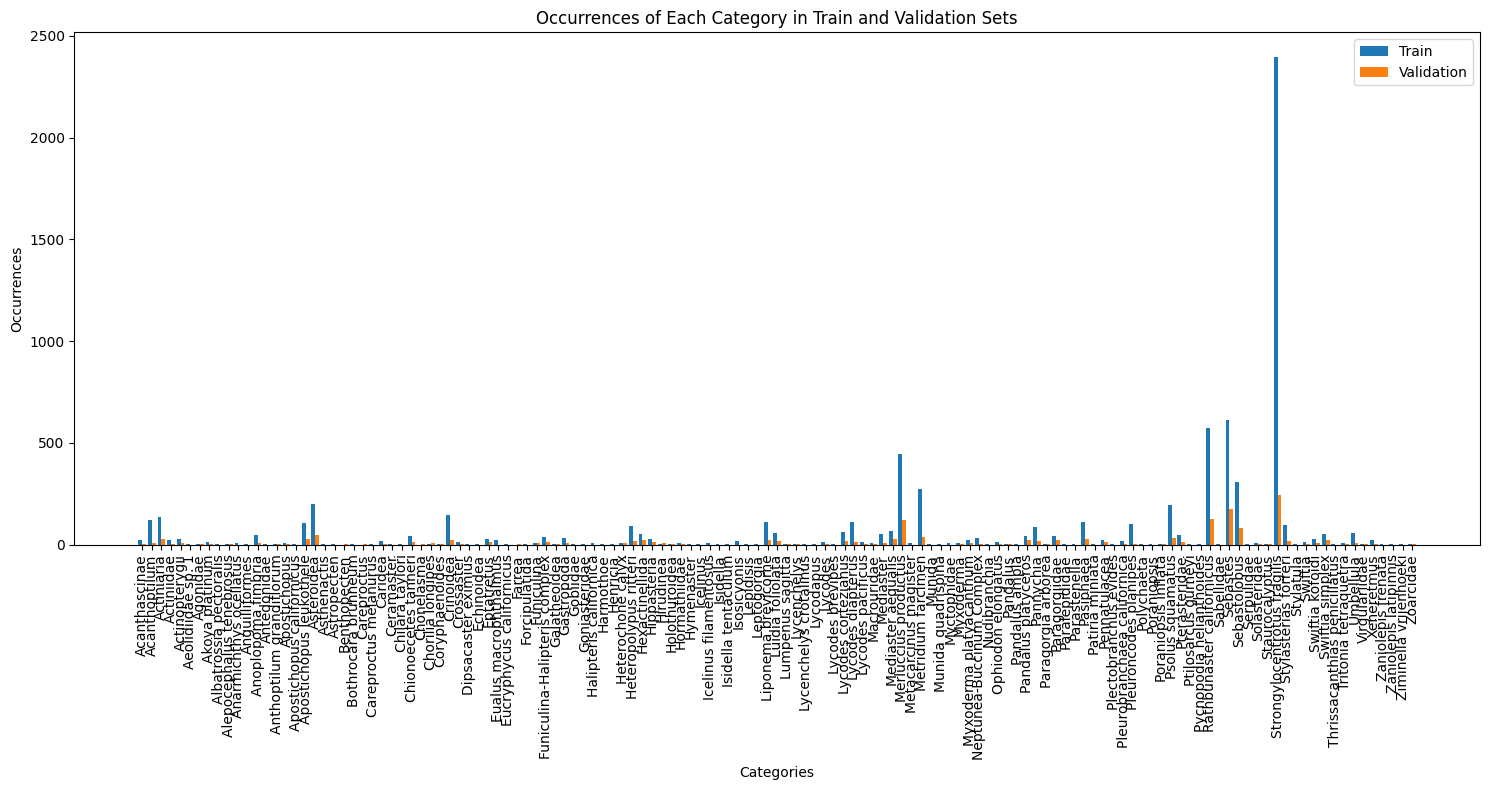

: 

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count occurrences of each category in train and val sets
train_counts = Counter(all_train_labels)
val_counts = Counter(all_val_labels)

# Get all unique categories
all_categories = sorted(set(train_counts.keys()) | set(val_counts.keys()))

# Prepare data for plotting
train_values = [train_counts.get(cat, 0) for cat in all_categories]
val_values = [val_counts.get(cat, 0) for cat in all_categories]

# Create barplot
x = range(len(all_categories))
plt.figure(figsize=(15, 8))
plt.bar(x, train_values, width=0.4, label='Train', align='center')
plt.bar([i + 0.4 for i in x], val_values, width=0.4, label='Validation', align='center')
plt.xlabel('Categories')
plt.ylabel('Occurrences')
plt.title('Occurrences of Each Category in Train and Validation Sets')
plt.xticks([i + 0.2 for i in x], all_categories, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()